# Adaptive stopping in a Bandit problem

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from compare_agents import MultipleAgentsComparator

from rlberry.agents.torch import DQNAgent, PPOAgent, A2CAgent
from rlberry.agents import RSUCBVIAgent
import pandas as pd

from rlberry.envs.bandits import BernoulliBandit
from rlberry.wrappers import WriterWrapper
from rlberry.agents.bandits import (
    IndexAgent,
    RandomizedAgent,
    makeBoundedIMEDIndex,
    makeBoundedMOSSIndex,
    makeBoundedNPTSIndex,
    makeBoundedUCBIndex,
    makeETCIndex,
)



We wish to reproduce the results in https://rlberry.readthedocs.io/en/latest/auto_examples/demo_bandits/plot_compare_index_bandits.html#sphx-glr-auto-examples-demo-bandits-plot-compare-index-bandits-py


## Problem setting

In [2]:
# Parameters of the problem
means = np.array([0.6, 0.6, 0.6, 0.9])  # means of the arms
A = len(means)
T = 2000  # Horizon

# Construction of the experiment

env_ctor = BernoulliBandit
env_kwargs = {"p": means}


class UCBAgent(IndexAgent):
    name = "UCB"

    def __init__(self, env, **kwargs):
        index, _ = makeBoundedUCBIndex()
        IndexAgent.__init__(self, env, index, **kwargs)
        self.env = WriterWrapper(
            self.env, self.writer, write_scalar="reward"
        )
    


class ETCAgent(IndexAgent):
    name = "ETC"

    def __init__(self, env, m=20, **kwargs):
        index, _ = makeETCIndex(A, m)
        IndexAgent.__init__(self, env, index, **kwargs)
        self.env = WriterWrapper(
            self.env, self.writer, write_scalar="action_and_reward"
        )

        
class MOSSAgent(IndexAgent):
    name = "MOSS"

    def __init__(self, env, **kwargs):
        index, _ = makeBoundedMOSSIndex(T, A)
        IndexAgent.__init__(self, env, index, **kwargs)
        self.env = WriterWrapper(
            self.env, self.writer, write_scalar="action_and_reward"
        )


class IMEDAgent(IndexAgent):
    name = "IMED"

    def __init__(self, env, **kwargs):
        index, tracker_params = makeBoundedIMEDIndex()
        IndexAgent.__init__(self, env, index, tracker_params=tracker_params, **kwargs)
        self.env = WriterWrapper(
            self.env, self.writer, write_scalar="reward"
        )

class NPTSAgent(IndexAgent):
    name = "NPTS"

    def __init__(self, env, **kwargs):
        index, tracker_params = makeBoundedNPTSIndex()
        IndexAgent.__init__(self, env, index, tracker_params=tracker_params, **kwargs)
        self.env = WriterWrapper(
            self.env, self.writer, write_scalar="reward"
        )


Agents_class = [
    MOSSAgent,
    IMEDAgent,
    NPTSAgent,
    UCBAgent,
    ETCAgent
]

managers = [
    (Agent,
        dict(
        train_env=(env_ctor, env_kwargs),
        fit_budget=T,
        parallelization="process",
        mp_context="fork")
    )
    for Agent in Agents_class
]


## Adastop algorithm

In [3]:
# we want to be able to see a difference of 5 and the std is around 10
n = 10
K = 10
B=10000
alpha = 0.05

In [4]:

n_managers = len(managers)
print('With these parameters, we have a maximum of {} fits done for each agent'.format(n*K))
print('Number of comparisons is {}'.format(n_managers*(n_managers-1)/2))

With these parameters, we have a maximum of 100 fits done for each agent
Number of comparisons is 10.0


let us now compare all the different algorithm

In [5]:
from rlberry.utils.logging import set_level
set_level('ERROR')

In [6]:
class Comparator(MultipleAgentsComparator):
    def __init__(self, **kwargs):
        MultipleAgentsComparator.__init__(self, **kwargs)
        
    def _get_evals(self, manager):
        """
        Compute the cumulative reward.
        """
        eval_values = []
        for idx in  manager.get_writer_data():
            df = manager.get_writer_data()[idx]
            eval_values.append(np.sum(np.max(means)-df.loc[df['tag']=='reward', 'value']))
        return eval_values

In [7]:
comparator  = Comparator(n=n, K=K, B=B, alpha=alpha, n_evaluations = 10, beta=0.01)

comparator.compare(managers)

print(comparator.decisions)
print(comparator.n_iters)

Step 0
reject
Step 1
Step 2
reject
reject
reject
Step 3
Step 4
Step 5
reject
Step 6
Step 7
Step 8
Step 9
reject
{'[0 1]': 'larger', '[0 2]': 'larger', '[0 3]': 'equal', '[0 4]': 'larger', '[1 2]': 'equal', '[1 3]': 'smaller', '[1 4]': 'equal', '[2 3]': 'smaller', '[2 4]': 'equal', '[3 4]': 'larger'}
{'MOSS': 100, 'IMED': 100, 'NPTS': 100, 'UCB': 30, 'ETC': 100}


In [8]:
comparator.n_iters

{'MOSS': 100, 'IMED': 100, 'NPTS': 100, 'UCB': 30, 'ETC': 100}

We reject the comparisons (1,3), (0,1), (0,2) , (2,3) and (0,3). Let us check graphically that this makes sense

In [9]:
comparator.eval_values

{'MOSS': array([23., 27., 23., 33., 23., 32., 32., 32., 38., 38., 59., 32.,  5.,
        20., 18., 46., 49., 26., 24., 36., 30., 31., 60., 15., 17., 15.,
        25., 39., 19., 15., 11., 11., 31., 32., 31., 37., 29., 44., 34.,
        20., 20., 29., 24., 61., 32., 28., 49., 67., 19., 18., 68.,  5.,
        42., 58., 15., 30., 10., 48., 29., 11.,  9., 12., 35., 22., 59.,
        38., 32., 37., -7., 31.,  9., 20., 42., 24., 20., 34., 34., 35.,
        40., 26., 34., 17., 29., 32., 33., 31., 18., 38., 39., 15., 60.,
        39., 16., 18., 27., 34.,  2., 18., 32., 54.]),
 'IMED': array([-1.30000000e+01, -2.00000000e+00, -3.00000000e+00, -1.00000000e+00,
         7.00000000e+00,  7.00000000e+00,  6.00000000e+00,  1.80000000e+01,
         2.20000000e+01,  3.70000000e+01,  1.00000000e+01,  3.00000000e+01,
         2.70000000e+01,  2.00000000e+00,  2.00000000e+00,  1.70000000e+01,
         1.90000000e+01, -3.00000000e+00, -2.90000000e+01,  3.40000000e+01,
        -8.00000000e+00,  5.00000000e+

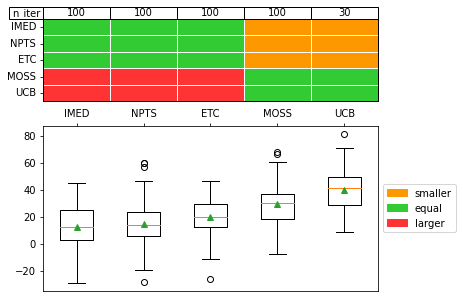

In [11]:
comparator.plot_results()

In [12]:
comparator.n_iters

{'MOSS': 100, 'IMED': 100, 'NPTS': 100, 'UCB': 30, 'ETC': 100}

In [13]:
comparator.agent_names

['MOSS', 'IMED', 'NPTS', 'UCB', 'ETC']